In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

import seaborn as sns

In [2]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [3]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# ##########################
# ### Apply notch filter ###
# ##########################

# outputSignal = signal.filtfilt(b_notch, a_notch, signal_corrupt)

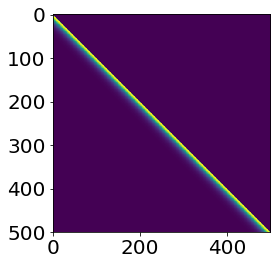

In [4]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

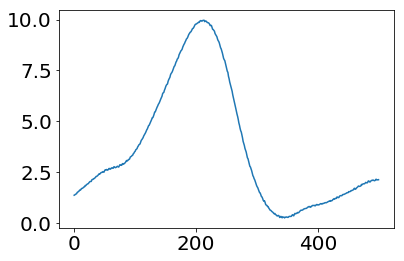

In [5]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"
#main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/corrected"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49-18,2000,4,500))
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

cluster_id = np.argmax(np.sum(responses_notch[20,:,0,:].real, axis=1))
plt.plot(responses_notch[20,cluster_id,0,:])

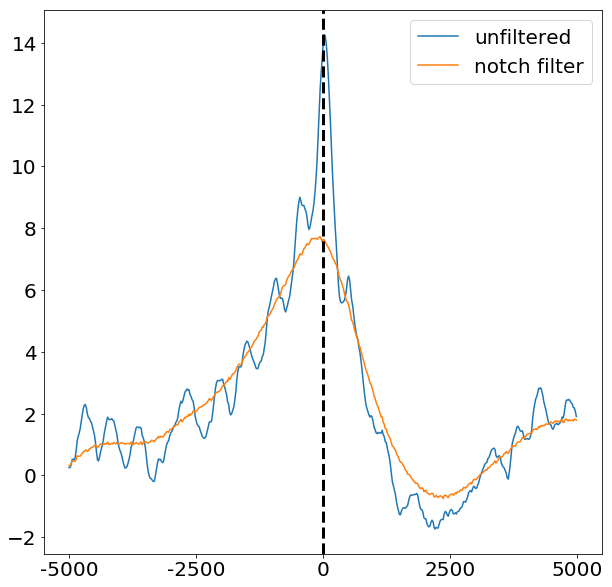

In [6]:
cluster_id=7
plt.figure(figsize=(10,10))
plt.plot(responses_split[20,cluster_id,0,:],label='unfiltered')
plt.plot(responses_notch[20,cluster_id,0,:],label='notch filter')
plt.legend()
plt.xticks([0,125,250,375,500],[-5000,-2500,0,2500,5000])
plt.axvline(250,linestyle='--',color='k',linewidth=3)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [7]:
##################
### Deconvolve ###
##################

all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(31*2000,4,500))
all_signals = np.reshape(responses_notch,(31*2000,4,500))

all_signals_flipped = all_signals[:,:,::-1]
all_signals_deconv = []
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    # flip filters in time
    temp = all_signals_flipped[:,beh_idx,:]

    # deconvolve
    deconv = np.linalg.lstsq(toe, temp.T)[0]
    deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

    # Remove edge artifact
    deconv_smooth[:5,:] = deconv_smooth[5,:]
    deconv_smooth[-5:,:] = deconv_smooth[-5,:]

    # Flip back to being backwards in time
    deconv_smooth = deconv_smooth[::-1,:]
    all_signals_deconv.append(deconv_smooth)
all_signals_deconv = np.asarray(all_signals_deconv)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,1)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,2)

0
1
2
3


In [8]:
######################
### Get peaks, etc ###
######################

all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)

peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    
    peaks_ = np.argmax(thresholded_filters,axis=-1)
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_

0
1
2
3


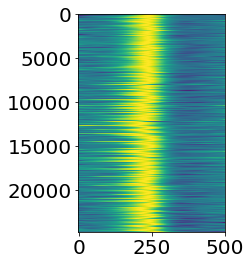

In [9]:
plt.imshow(thresholded_filters_norm[0],aspect=.03)

In [33]:
fwhms = []
for i in range(len(thresholded_filters_norm[0])):
    fwhm,_,_,_ = scipy.signal.peak_widths(thresholded_filters_norm[0][i],[peaks[0][i]])
    fwhms.append(int(fwhm))

20.0

0.48980531252452286 0.0


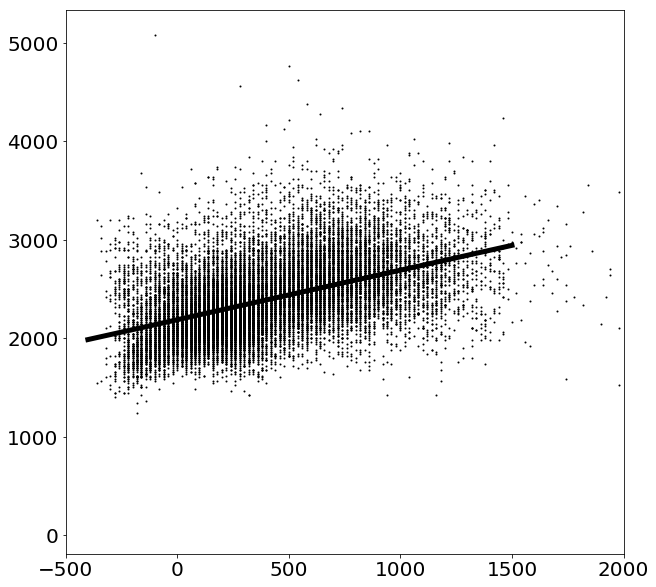

In [62]:
plt.figure(figsize=(10,10))

xs = [(500-i-250)*20 for i in peaks[0]]
ys = [i*20 for i in fwhms]

plt.plot(xs,ys,color='k',linestyle='',marker='o',ms=1)

m, b = np.polyfit(xs, ys, 1)
x=[-400,1500]
plt.plot(x, [i*m + b for i in x],lw=5,color='k')
r, p = scipy.stats.pearsonr(xs, ys)
print(r,p)

plt.xlim(-500,2000)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [42]:
peaks[0]

array([229, 229, 235, ..., 241, 202, 225])

In [26]:
m

array([136.04035745])

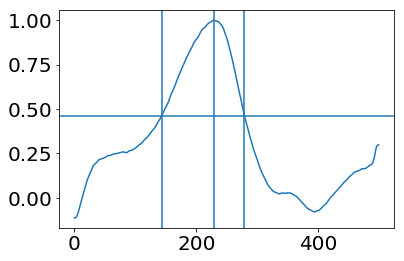

In [19]:
plt.plot(thresholded_filters_norm[0][0])
plt.axvline(peaks[0][0])
plt.axvline(143)
plt.axvline(279)
plt.axhline(.46)

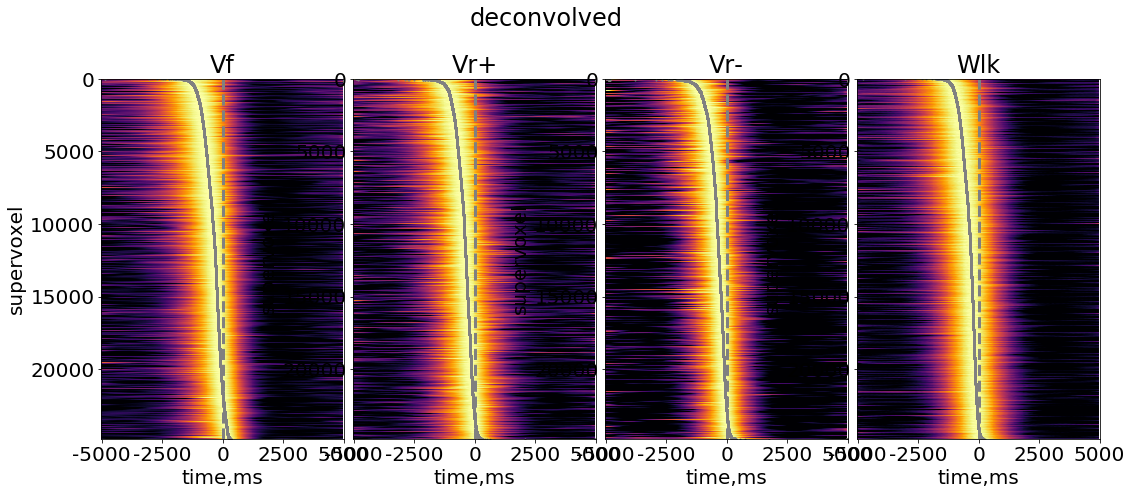

In [9]:
fig = plt.figure(figsize=(10,10))
timepoints = list(range(-5000,0,20)) + list(range(0,5000,20))
behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

for beh_idx in [0,1,2,3]:
    ax = fig.add_axes([beh_idx*.35, 0, .5, .5])
    
    plt.imshow(thresholded_filters_norm[beh_idx][np.argsort(peaks[beh_idx]),:],aspect=.03,cmap='inferno',vmin=0,vmax=1)

    plt.axvline(250,linestyle='--',color='grey',linewidth=3)
    plt.plot(peaks[beh_idx][list(np.argsort(peaks[beh_idx]))],list(range(len(peaks[beh_idx]))),marker='o',linestyle='',color='grey',ms=1)
    plt.xticks([0,125,250,375,500],[-5000,-2500,0,2500,5000])
    plt.xlabel('time,ms')
    plt.ylabel('supervoxel')
    plt.title(behs[beh_idx])
    #plt.xlim(150,300)

plt.suptitle('deconvolved',x=0.7,y=.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [10]:
### ok so we need to split by ROIs
# we are starting with supervoxels
# I could warp the 4D single voxel map through

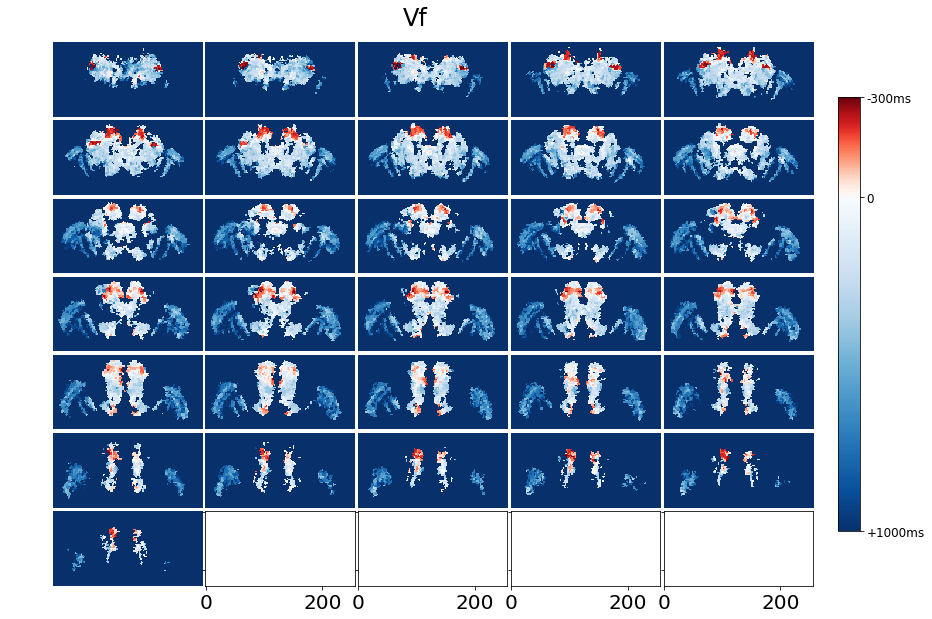

In [9]:
for beh_idx in [0]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = 0 #np.nan #<--------------------

    start = 265
    end = 200
    middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
#     start = 235
#     end = 190
    #middle = 250

    # sample the colormaps that you want to use. Use 128 from each so we get 256
    # colors in total
    colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
    colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
        grid[i].axis('off')

    cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['-300ms', '0', '+1000ms'], fontsize=12)

#     cbar = fig.colorbar(cax, ticks=[start, end],shrink=.8, anchor=(.1,.5))
#     cbar.ax.set_yticklabels(['+300ms', '+1000ms'], fontsize=12)

    plt.suptitle(f'{behs[beh_idx]}',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    #plt.savefig(fname,dpi=300,bbox_inches='tight')

In [10]:
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke_lowres.nii"
luke = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')

In [11]:
all_colored_by_betas.shape

(31, 256, 128)

(256, 128, 4)
(256, 128, 4)


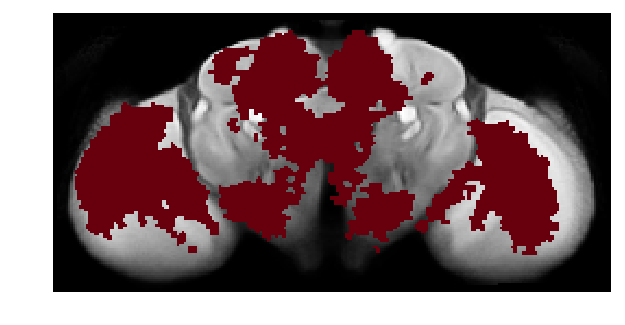

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(luke[:,:,25].T,cmap='gray')
alphas = Normalize(.0001, .01, clip=True)(np.abs(all_colored_by_betas[25-9,:,:]))
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = all_colored_by_betas[25-9,:,:]
cmap = mymap
colors = cmap(colors)
# Now set the alpha channel to the one we created above
print(colors.shape)
colors[..., -1] = alphas
print(colors.shape)
plt.imshow(np.swapaxes(colors,0,1),vmin=0,vmax=.01)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [29]:
colors

array([[[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ]],

       [[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ]],

       [[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.188235

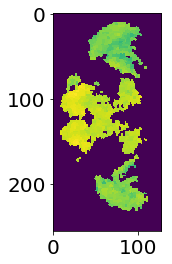

In [24]:
plt.imshow(all_colored_by_betas[25-9,:,:])

In [23]:
colors

array([[[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ]],

       [[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ]],

       [[0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        ...,
        [0.03137255, 0.18823529, 0.41960784, 0.        ],
        [0.03137255, 0.188235

In [12]:
thresholded_filters_norm[0].shape

(24800, 500)

In [13]:
peaks[0].shape

(24800,)

In [14]:
for beh_idx in [0]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros((62000,500))
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace,:] = thresholded_filters_norm[beh_idx] 
    to_plot = np.reshape(add_deleted_voxels, (31,2000,500))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros((256*128,500))
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies,:] = to_plot[z-9,cluster_num,:]
        colored_by_betas = colored_by_betas.reshape(256,128,500)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    #all_colored_by_betas[all_colored_by_betas==0] = 0 #np.nan #<--------------------

In [15]:
all_colored_by_betas.shape

(31, 256, 128, 500)

In [16]:
pad = np.zeros((9,256,128,500))
all_colored_by_betas_full = np.concatenate((pad,all_colored_by_betas,pad))
all_colored_by_betas_full = np.moveaxis(all_colored_by_betas_full,0,2)
all_colored_by_betas_full.shape

(256, 128, 49, 500)

In [17]:
moving = ants.from_numpy(all_colored_by_betas_full[:,:,::-1])
moving.set_spacing((2.6076, 2.6154, 5.3125,1)) ### matching this to the slightly off luke mean

In [18]:
### Load Luke Mean ###

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [19]:
### Load JFRC2018 ###

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [20]:
### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [21]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [22]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], 
                                       imagetype=3,interpolator='nearestNeighbor')

In [23]:
# del maps_voxel_res
# del moving
# del all_colored_by_betas_full
del all_signals_deconv

In [24]:
import gc
gc.collect()

27

In [25]:
temporal_map = maps_voxel_res.numpy()

In [26]:
temporal_map.shape

(314, 146, 91, 500)

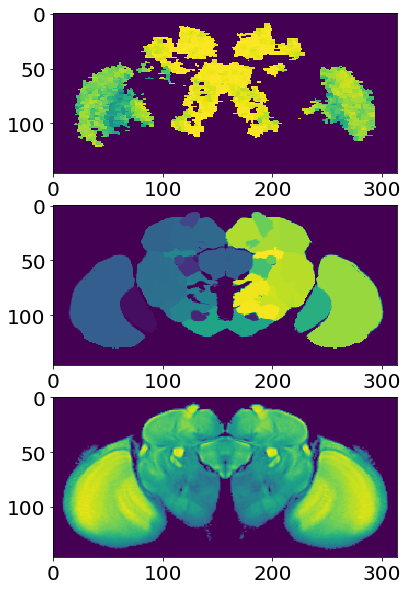

In [27]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(temporal_map[:,:,z,250].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

(-0.5, 313.5, 145.5, -0.5)

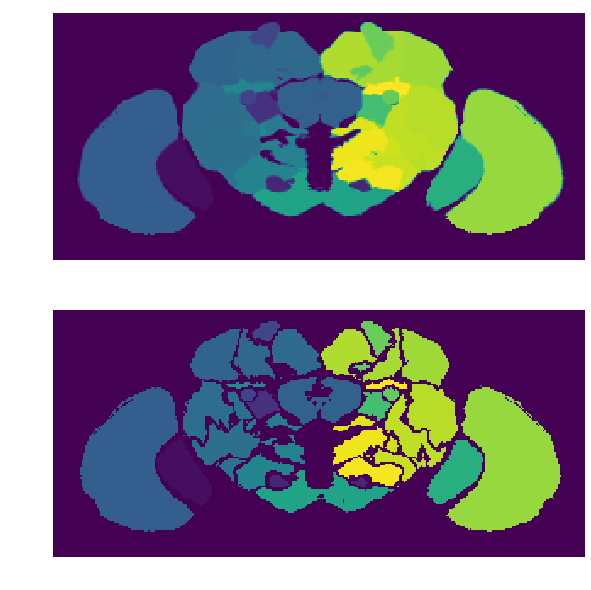

In [28]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [29]:
##################
### ROI GROUPS ###
##################

full_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L',
6: 'PB',
23: 'EB',
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L',
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',#####
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R',
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L',
}

full_right_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
54: 'BU_L',
56: 'LAL_L',
76: 'PVLP_L',
####################
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
####################
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
75: 'AVLP_L',
77: 'IVLP_L',
57: 'CAN_L',
67: 'FLA_L',
50: 'PRW',
9: 'SAD',
49: 'GNG', 
####################
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
###################
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L' 
}

full_left_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
5: 'BU_R',
8: 'LAL_R',
31: 'PVLP_R',
##################
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
##################
24: 'AL_R',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
30: 'AVLP_R',
32: 'IVLP_R',
10: 'CAN_R',
20: 'FLA_R',
50: 'PRW',
9: 'SAD',
49: 'GNG',
###################    
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',
###################
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R'
}

In [30]:
temporal_map.shape

(314, 146, 91, 500)

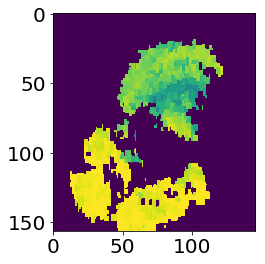

In [36]:
plt.imshow(temporal_map[:157,:,50,250])

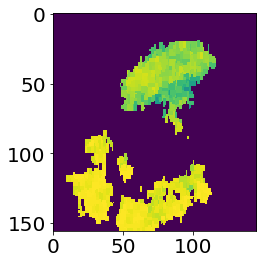

In [48]:
plt.imshow(temporal_map[:157:-1,:,50,250])

In [ ]:
# MIRROR if desired

temporal_map_mirror = np.

In [31]:
temporal_map_flatish = np.reshape(temporal_map,(-1,500))

In [38]:
temporal_map_flatish.shape

(4171804, 500)

In [32]:
### Need to get num_voxels in each mask with a response so can take max(L,R) and add necessary spacers

In [33]:
roi_voxels = {}
peaks = {}
num_voxels = {}

for roi in full_group.keys():
    mask = np.zeros(atlas_clean.shape)
    mask[np.where(atlas_clean == roi)] = 1
    mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)
    mask_dilated = mask_dilated.flatten()
    roi_voxels_temp = temporal_map_flatish[np.where(mask_dilated == True)]
    
    #remove voxels with no response
    roi_voxels[roi] = roi_voxels_temp[np.where(np.sum(roi_voxels_temp,axis=-1)>0)]
    
    #get peaks
    peaks[roi] = np.argmax(roi_voxels[roi],axis=-1)
    
    num_voxels[roi] = len(peaks[roi][np.argsort(peaks[roi])])

In [31]:
import pickle

In [32]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210930_cc_peaks'
fname = os.path.join(directory, 'fwd')
with open(fname, 'wb') as handle:
    pickle.dump(peaks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
rot_pos_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210930_cc_peaks/rot_pos'
with open(rot_pos_file, 'rb') as handle:
    peaks_pos = pickle.load(handle)
    
rot_neg_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210930_cc_peaks/rot_neg'
with open(rot_neg_file, 'rb') as handle:
    peaks_neg = pickle.load(handle)

In [27]:
# if pos, there are more voxels in left
num_voxels_diff = []
for k, roi in enumerate(full_left_group.keys()):
    num_voxels_diff.append(num_voxels[roi] - num_voxels[list(full_right_group.keys())[k]])

In [28]:
######################
### Sort and Stack ###
######################

### LEFT
stacked_L = np.zeros((0,500))
peaks_stacked_L = []
source_starts_L = [0]
dest_starts_L = [0]
for k, roi in enumerate(full_left_group.keys()):
    if num_voxels_diff[k] > 0:
        spacer = np.zeros((0,500))
    else:
        spacer = np.zeros((-num_voxels_diff[k],500))
    stacked_L = np.concatenate((stacked_L, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1],spacer))
    peaks_stacked_L.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
    # we want to create a list of "starts" and "ends" for "source" and "destination"
    # source starts/ends will just be a list of cum_sum voxel counts without spacers
    # dest starts/ends will include the spacers
    source_starts_L.append(roi_voxels[roi].shape[0])
    if spacer.shape[0] > 0:
        dest_starts_L.append(roi_voxels[roi].shape[0] + spacer.shape[0])
    else:
        dest_starts_L.append(roi_voxels[roi].shape[0])
    
### RIGHT
stacked_R = np.zeros((0,500))
peaks_stacked_R = []
source_starts_R = [0]
dest_starts_R = [0]
for k,roi in enumerate(full_right_group.keys()):
    if num_voxels_diff[k] > 0:
        spacer = np.zeros((num_voxels_diff[k],500))
    else:
        spacer = np.zeros((0,500))
    stacked_R = np.concatenate((stacked_R, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1],spacer))
    peaks_stacked_R.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
    source_starts_R.append(roi_voxels[roi].shape[0])
    if spacer.shape[0] > 0:
        dest_starts_R.append(roi_voxels[roi].shape[0] + spacer.shape[0])
    else:
        dest_starts_R.append(roi_voxels[roi].shape[0])

In [36]:
######################
### Sort and Stack - removed spacers ###
######################

### LEFT
stacked_L = np.zeros((0,500))
peaks_stacked_L = []
source_starts_L = [0]
dest_starts_L = [0]
for k, roi in enumerate(full_left_group.keys()):
    #if num_voxels_diff[k] > 0:
    spacer = np.zeros((0,500))
#     else:
#         spacer = np.zeros((-num_voxels_diff[k],500))
    stacked_L = np.concatenate((stacked_L, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1],spacer))
    peaks_stacked_L.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
    # we want to create a list of "starts" and "ends" for "source" and "destination"
    # source starts/ends will just be a list of cum_sum voxel counts without spacers
    # dest starts/ends will include the spacers
    source_starts_L.append(roi_voxels[roi].shape[0])
#     if spacer.shape[0] > 0:
#         dest_starts_L.append(roi_voxels[roi].shape[0] + spacer.shape[0])
#     else:
    dest_starts_L.append(roi_voxels[roi].shape[0])
    
# ### RIGHT
# stacked_R = np.zeros((0,500))
# peaks_stacked_R = []
# source_starts_R = [0]
# dest_starts_R = [0]
# for k,roi in enumerate(full_right_group.keys()):
#     if num_voxels_diff[k] > 0:
#         spacer = np.zeros((num_voxels_diff[k],500))
#     else:
#         spacer = np.zeros((0,500))
#     stacked_R = np.concatenate((stacked_R, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1],spacer))
#     peaks_stacked_R.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
#     source_starts_R.append(roi_voxels[roi].shape[0])
#     if spacer.shape[0] > 0:
#         dest_starts_R.append(roi_voxels[roi].shape[0] + spacer.shape[0])
#     else:
#         dest_starts_R.append(roi_voxels[roi].shape[0])

In [37]:
source_starts_L

[0,
 2413,
 10603,
 1909,
 797,
 117,
 6820,
 3775,
 3307,
 997,
 480,
 1024,
 6990,
 2764,
 3454,
 7993,
 1829,
 2170,
 1207,
 15,
 2,
 0,
 2860,
 4822,
 11714,
 11816,
 9772,
 11352,
 10610,
 7871,
 8043,
 6394,
 4525,
 1265,
 4619,
 4320,
 74720,
 31206,
 2133,
 3012]

In [36]:
cum_source_starts_L

array([     0,   2413,  13016,  14925,  15722,  15839,  22659,  26434,
        29741,  30738,  31218,  32242,  39232,  41996,  45450,  53443,
        55272,  57442,  58649,  58664,  58666,  58666,  61526,  66348,
        78062,  89878,  99650, 111002, 121612, 129483, 137526, 143920,
       148445, 149710, 154329, 158649, 233369, 264575, 266708, 269720])

In [34]:
1

1

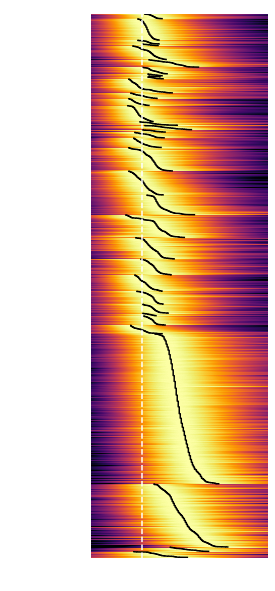

In [37]:
cum_source_starts_L = np.cumsum(source_starts_L)
cum_dest_starts_L = np.cumsum(dest_starts_L)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(stacked_L,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
c = 100
for i in range(len(cum_source_starts_L)-1):
    num_vox = cum_source_starts_L[i+1] - cum_source_starts_L[i] - 2*c
    plt.plot(peaks_stacked_L[cum_source_starts_L[i]+c:cum_source_starts_L[i+1]-c],
             list(range(cum_dest_starts_L[i],cum_dest_starts_L[i]+num_vox)),color='k')
plt.axvline(250,color='w',linestyle='--')
plt.xlim(200,375)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

# plt.subplot(122)
# plt.imshow(stacked_R,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
# c = 100
# for i in range(len(cum_source_starts_R)-1):
#     num_vox = cum_source_starts_R[i+1] - cum_source_starts_R[i] - 2*c
#     plt.plot(peaks_stacked_R[cum_source_starts_R[i]+c:cum_source_starts_R[i+1]-c],
#              list(range(cum_dest_starts_R[i],cum_dest_starts_R[i]+num_vox)),color='k')
# plt.axvline(250,color='k')
# plt.xlim(200,375)
# plt.axis('off')

In [81]:
######################
### Sort and Stack  - no spacers ###
######################

### LEFT
stacked_L = np.zeros((0,500))
peaks_stacked_L = []
source_starts_L = [0]
dest_starts_L = [0]
for k, roi in enumerate(full_left_group.keys()):
    stacked_L = np.concatenate((stacked_L, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1]))
    peaks_stacked_L.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
    # we want to create a list of "starts" and "ends" for "source" and "destination"
    # source starts/ends will just be a list of cum_sum voxel counts without spacers
    # dest starts/ends will include the spacers
    source_starts_L.append(roi_voxels[roi].shape[0])
#     if spacer.shape[0] > 0:
#         dest_starts_L.append(roi_voxels[roi].shape[0] + spacer.shape[0])
#     else:
#         dest_starts_L.append(roi_voxels[roi].shape[0])
    
# ### RIGHT
# stacked_R = np.zeros((0,500))
# peaks_stacked_R = []
# source_starts_R = [0]
# dest_starts_R = [0]
# for k,roi in enumerate(full_right_group.keys()):
# #     if num_voxels_diff[k] > 0:
# #         spacer = np.zeros((num_voxels_diff[k],500))
# #     else:
# #         spacer = np.zeros((0,500))
#     stacked_R = np.concatenate((stacked_R, roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1]))
#     peaks_stacked_R.extend(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250)
    
# #     source_starts_R.append(roi_voxels[roi].shape[0])
# #     if spacer.shape[0] > 0:
# #         dest_starts_R.append(roi_voxels[roi].shape[0] + spacer.shape[0])
# #     else:
# #         dest_starts_R.append(roi_voxels[roi].shape[0])

In [82]:
source_starts_L

[0,
 2418,
 10583,
 1895,
 799,
 119,
 6808,
 3780,
 3284,
 996,
 490,
 1019,
 6950,
 2762,
 3411,
 7988,
 1833,
 2175,
 1196,
 15,
 2,
 0,
 2859,
 4757,
 11605,
 11737,
 9803,
 11328,
 10599,
 7862,
 8044,
 6384,
 4540,
 1265,
 4617,
 4304,
 74377,
 31295,
 2184,
 3010]

In [83]:
cum_source_starts_L = np.cumsum(source_starts_L)

(200.0, 375.0, 269092.5, -0.5)

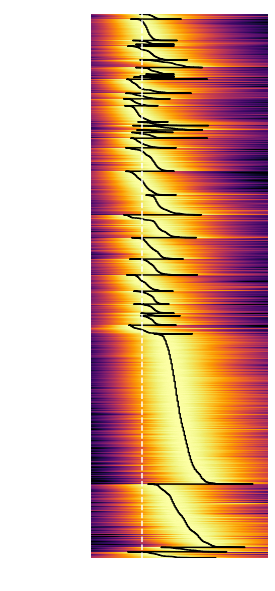

In [80]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(stacked_L,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
for i in range(source_starts_L):
    plt.plot(peaks_stacked_L,np.arange(0,len(peaks_stacked_L)),color='k')
plt.axvline(250,color='w',linestyle='--')
plt.xlim(200,375)
plt.axis('off')

In [29]:
len(full_left_group.keys())

39

In [30]:
cum_source_starts_L = np.cumsum(source_starts_L)
cum_dest_starts_L = np.cumsum(dest_starts_L)
cum_source_starts_R = np.cumsum(source_starts_R)
cum_dest_starts_R = np.cumsum(dest_starts_R)

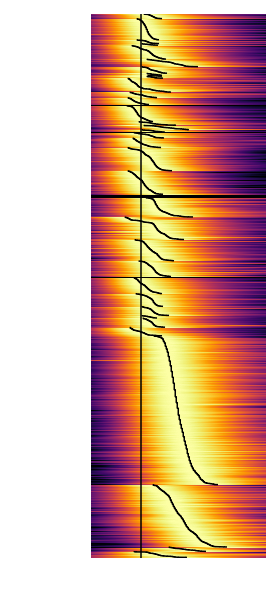

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(stacked_L,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
c = 100
for i in range(len(cum_source_starts_L)-1):
    num_vox = cum_source_starts_L[i+1] - cum_source_starts_L[i] - 2*c
    plt.plot(peaks_stacked_L[cum_source_starts_L[i]+c:cum_source_starts_L[i+1]-c],
             list(range(cum_dest_starts_L[i],cum_dest_starts_L[i]+num_vox)),color='k')
plt.axvline(250,color='k')
plt.xlim(200,375)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# plt.subplot(122)
# plt.imshow(stacked_R,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
# c = 100
# for i in range(len(cum_source_starts_R)-1):
#     num_vox = cum_source_starts_R[i+1] - cum_source_starts_R[i] - 2*c
#     plt.plot(peaks_stacked_R[cum_source_starts_R[i]+c:cum_source_starts_R[i+1]-c],
#              list(range(cum_dest_starts_R[i],cum_dest_starts_R[i]+num_vox)),color='k')
# plt.axvline(250,color='k')
# plt.xlim(200,375)
# plt.axis('off')

In [31]:
hist, bin_edges = np.histogram(peaks[25], bins=20, range=(175,275))

In [32]:
### Normalized histograms of peak times per ROI ###

# lets do this manually, then can make a heat plot of 1D hists

hist_stacked = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked = np.concatenate((hist_stacked,hist[np.newaxis,:]))

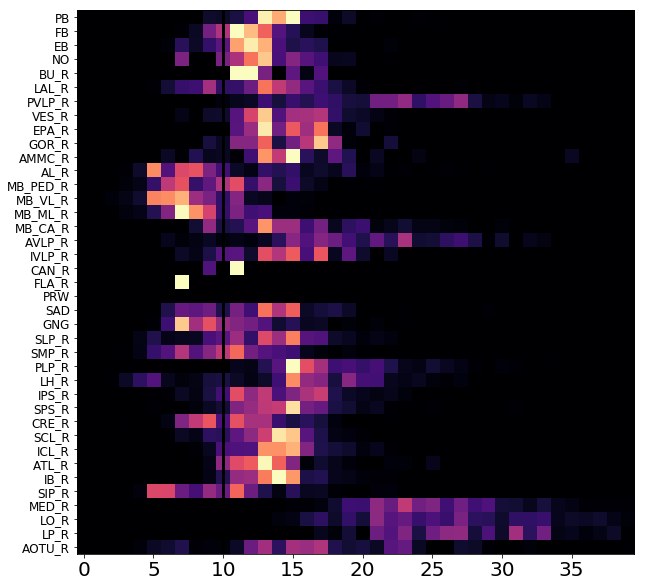

In [346]:
plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(np.nan_to_num(hist_stacked[:,::-1]),vmin=0,vmax=.1,cmap='magma')
plt.axvline(10,color='k',lw=3)
ax.set_yticks(list(range(39)))
ax.set_yticklabels(full_left_group.values(), fontsize=12);

In [36]:
hist_stacked_right_pos.shape

(39, 40)

In [38]:
hist_stacked.shape

(39, 40, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


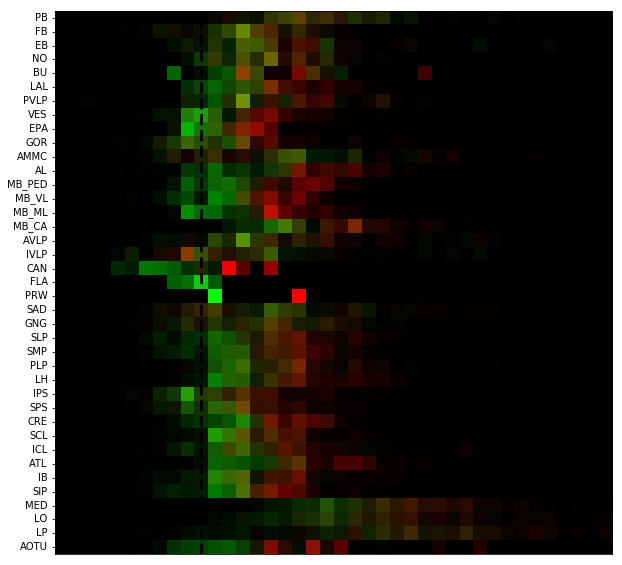

In [42]:
# To plot green/red L/R on top of each other, will probably need to make the RGB channels. easy.
### Normalized histograms of peak times per ROI ###

# lets do this manually, then can make a heat plot of 1D hists

hist_stacked_right_pos = np.zeros((0,40))
for k, roi in enumerate(full_right_group.keys()):
    hist, bin_edges = np.histogram(peaks_pos[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right_pos = np.concatenate((hist_stacked_right_pos,hist[np.newaxis,:]))
    
hist_stacked_right_neg = np.zeros((0,40))
for k, roi in enumerate(full_right_group.keys()):
    hist, bin_edges = np.histogram(peaks_neg[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right_neg = np.concatenate((hist_stacked_right_neg,hist[np.newaxis,:]))

hist_stacked = np.stack((hist_stacked_right_pos, hist_stacked_right_neg, np.zeros(hist_stacked_right_pos.shape))) 
hist_stacked = np.moveaxis(hist_stacked,0,2)
hist_stacked = hist_stacked*5

# hist_stacked_left = np.zeros((0,40))
# for k, roi in enumerate(full_left_group.keys()):
#     hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
#     hist_stacked_left = np.concatenate((hist_stacked_left,hist[np.newaxis,:]))
    
#hist_stacked = (hist_stacked_right+hist_stacked_left)/2
#hist_stacked = hist_stacked_left
    
plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(np.nan_to_num(hist_stacked[:,::-1,:]),vmin=0,vmax=.1) #Blues
plt.axvline(10,color='k',lw=3,linestyle='--')
# ax.set_yticks(list(range(39)))
# ax.set_yticklabels(full_right_group.values(), fontsize=12);


##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


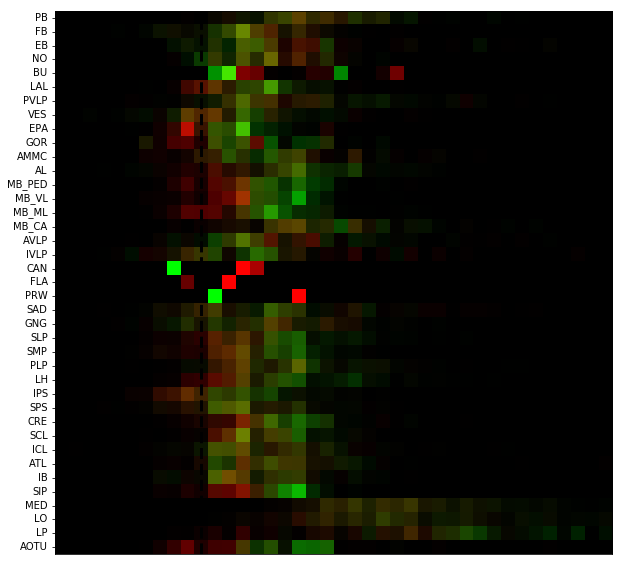

In [43]:
# To plot green/red L/R on top of each other, will probably need to make the RGB channels. easy.
### Normalized histograms of peak times per ROI ###

# lets do this manually, then can make a heat plot of 1D hists

hist_stacked_right_pos = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks_pos[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right_pos = np.concatenate((hist_stacked_right_pos,hist[np.newaxis,:]))
    
hist_stacked_right_neg = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks_neg[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right_neg = np.concatenate((hist_stacked_right_neg,hist[np.newaxis,:]))

hist_stacked = np.stack((hist_stacked_right_pos, hist_stacked_right_neg, np.zeros(hist_stacked_right_pos.shape))) 
hist_stacked = np.moveaxis(hist_stacked,0,2)
hist_stacked = hist_stacked*5

# hist_stacked_left = np.zeros((0,40))
# for k, roi in enumerate(full_left_group.keys()):
#     hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
#     hist_stacked_left = np.concatenate((hist_stacked_left,hist[np.newaxis,:]))
    
#hist_stacked = (hist_stacked_right+hist_stacked_left)/2
#hist_stacked = hist_stacked_left
    
plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(np.nan_to_num(hist_stacked[:,::-1,:]),vmin=0,vmax=.1) #Blues
plt.axvline(10,color='k',lw=3,linestyle='--')
# ax.set_yticks(list(range(39)))
# ax.set_yticklabels(full_right_group.values(), fontsize=12);


##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

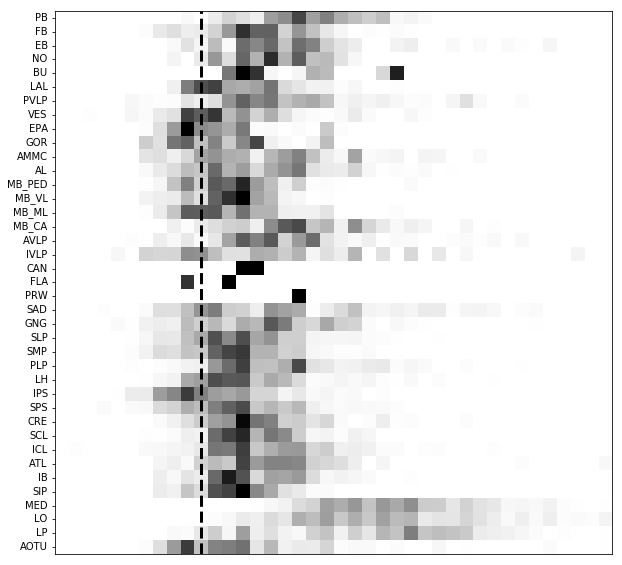

In [36]:
### Normalized histograms of peak times per ROI ###

# lets do this manually, then can make a heat plot of 1D hists

hist_stacked_right = np.zeros((0,40))
for k, roi in enumerate(full_right_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right = np.concatenate((hist_stacked_right,hist[np.newaxis,:]))
    
hist_stacked_left = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked_left = np.concatenate((hist_stacked_left,hist[np.newaxis,:]))
    
#hist_stacked = (hist_stacked_right+hist_stacked_left)/2
hist_stacked = hist_stacked_left
    
plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(np.nan_to_num(hist_stacked[:,::-1]),vmin=0,vmax=.1,cmap='gray_r') #Blues
plt.axvline(10,color='k',lw=3,linestyle='--')
# ax.set_yticks(list(range(39)))
# ax.set_yticklabels(full_right_group.values(), fontsize=12);


##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [28]:
1

1

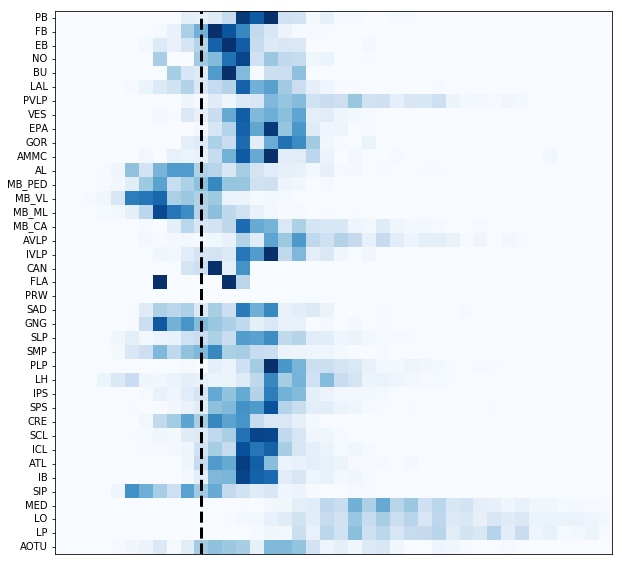

In [44]:
### Normalized histograms of peak times per ROI ###

# lets do this manually, then can make a heat plot of 1D hists

hist_stacked_right = np.zeros((0,40))
for k, roi in enumerate(full_right_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked_right = np.concatenate((hist_stacked_right,hist[np.newaxis,:]))
    
hist_stacked_left = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked_left = np.concatenate((hist_stacked_left,hist[np.newaxis,:]))
    
hist_stacked = (hist_stacked_right+hist_stacked_left)/2
    
plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(np.nan_to_num(hist_stacked[:,::-1]),vmin=0,vmax=.1,cmap='Blues')
plt.axvline(10,color='k',lw=3,linestyle='--')
# ax.set_yticks(list(range(39)))
# ax.set_yticklabels(full_right_group.values(), fontsize=12);


##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

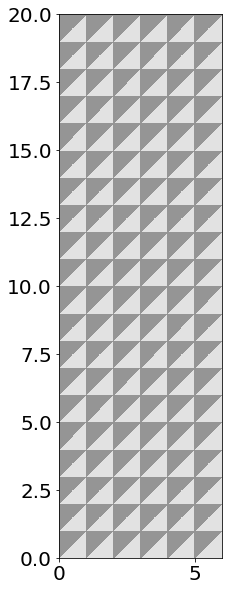

In [33]:
def trianglematrix(upper_triangle, lower_triangle, ax=None, triplotkw={},tripcolorkw={}):
    right=lower_triangle
    left=lower_triangle
    bottom=upper_triangle
    top=upper_triangle
    
    if not ax: ax=plt.gca()
    n = left.shape[0]; m=left.shape[1]

    a = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]])
    tr = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]])
    tr = np.array([[0,2,3],[0,1,2],[2,3,4],[1,2,4]]) # swaping first and 2nd sets somehow makes edges better


    A = np.zeros((n*m*5,2))
    Tr = np.zeros((n*m*4,3))

    for i in range(n):
        for j in range(m):
            k = i*m+j
            A[k*5:(k+1)*5,:] = np.c_[a[:,0]+j, a[:,1]+i]
            Tr[k*4:(k+1)*4,:] = tr + k*5

    C = np.c_[ left.flatten(), bottom.flatten(), 
              right.flatten(), top.flatten()   ].flatten()

    triplot = ax.triplot(A[:,0], A[:,1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:,0], A[:,1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

upper_triangle = np.ones((20,6))*.5
lower_triangle = np.ones((20,6))*.2
fig, ax=plt.subplots(figsize=(10,10))
trianglematrix(upper_triangle, lower_triangle, ax=ax,
             triplotkw={"color":"k", "lw":0},
             tripcolorkw={"cmap": "Greys", "vmin": "0", "vmax": "1"}) 
ax.margins(0)
ax.set_aspect("equal")

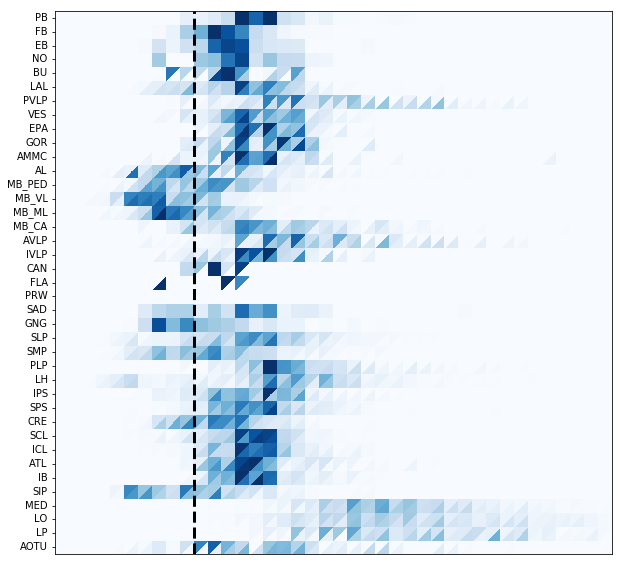

In [35]:
############
### PLOT ###
############


hist_stacked = np.zeros((0,40))
for k, roi in enumerate(full_right_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked = np.concatenate((hist_stacked,hist[np.newaxis,:]))
    
upper_triangle = np.nan_to_num(hist_stacked[::-1,::-1])

hist_stacked = np.zeros((0,40))
for k, roi in enumerate(full_left_group.keys()):
    hist, bin_edges = np.histogram(peaks[roi], bins=40, range=(175,275), density=True)
    hist_stacked = np.concatenate((hist_stacked,hist[np.newaxis,:]))

lower_triangle = np.nan_to_num(hist_stacked[::-1,::-1])
fig, ax=plt.subplots(figsize=(10,10))
trianglematrix(upper_triangle, lower_triangle, ax=ax,
             triplotkw={"color":"k", "lw":0},
             tripcolorkw={"cmap": "Blues", "vmin": "0", "vmax": "0.1"}) 
ax.margins(0)
ax.set_aspect("equal")

plt.axvline(10,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names = []
for name in full_left_group.values():
    if '_R' in name:
        names.append(name[:-2])
    else:
        names.append(name)
names = names[::-1] #need to swap y-order
        
ax.set_yticks([i+.5 for i in np.arange(len(names))]);
ax.set_xticks([]);
ax.set_yticklabels(names);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [315]:
bin_edges

array([175., 180., 185., 190., 195., 200., 205., 210., 215., 220., 225.,
       230., 235., 240., 245., 250., 255., 260., 265., 270., 275.])

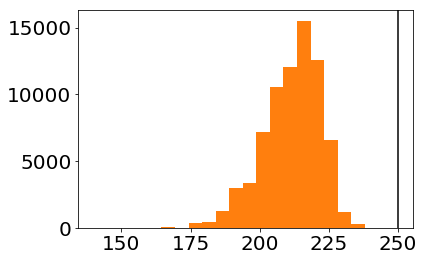

In [301]:
n,bins,patch = plt.hist(peaks[25],bins=20);
plt.hist(peaks[25],bins=20);
plt.axvline(250,color='k')

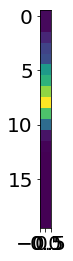

In [306]:
plt.imshow(hist[:,np.newaxis])

In [36]:
for k in full_left_group.keys():
    print(k)

6
26
23
4
5
8
31
13
40
35
11
24
17
18
19
36
30
32
10
20
50
9
49
27
29
33
7
38
37
16
39
12
15
14
28
25
3
22
34


In [41]:
peaks[3]

array([208, 207, 207, ..., 232, 232, 232])

(175, 275)

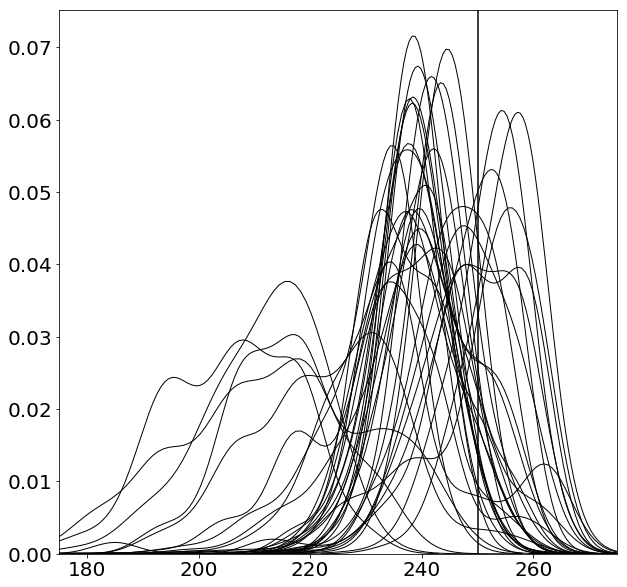

In [43]:
plt.figure(figsize=(10,10))
for k in full_left_group.keys():
    if k not in [5,10,20,50]:
        sns.distplot(peaks[k], hist = False, kde = True, color='k',
                     kde_kws = {'shade': False, 'linewidth': 1, 'bw':4})
# for k in full_right_group.keys():
#     sns.distplot(peaks[k], hist = False, kde = True, color='r',
#                  kde_kws = {'shade': False, 'linewidth': 1, 'bw':2})
plt.axvline(250,color='k')
plt.xlim(175,275)
#50 steps is a sec
#so, 10steps is 200ms

(175, 275)

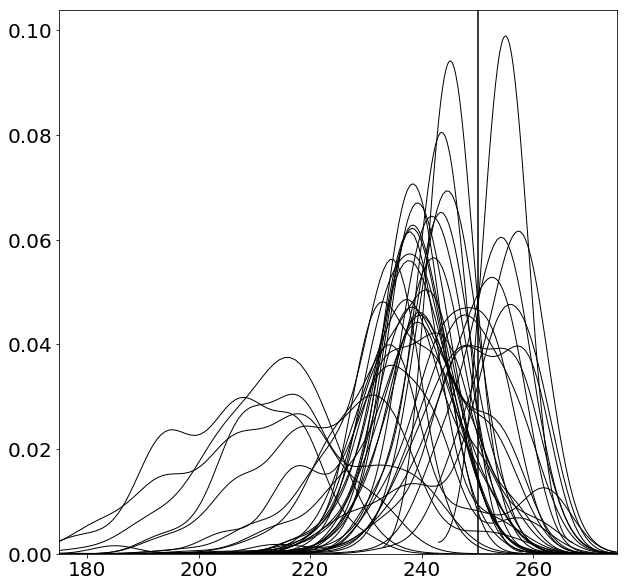

In [293]:
plt.figure(figsize=(10,10))
for k in full_left_group.keys():
    sns.distplot(peaks[k], hist = False, kde = True, color='k',
                 kde_kws = {'shade': False, 'linewidth': 1, 'bw':4})
# for k in full_right_group.keys():
#     sns.distplot(peaks[k], hist = False, kde = True, color='r',
#                  kde_kws = {'shade': False, 'linewidth': 1, 'bw':2})
plt.axvline(250,color='k')
plt.xlim(175,275)
#50 steps is a sec
#so, 10steps is 200ms

(200, 375)

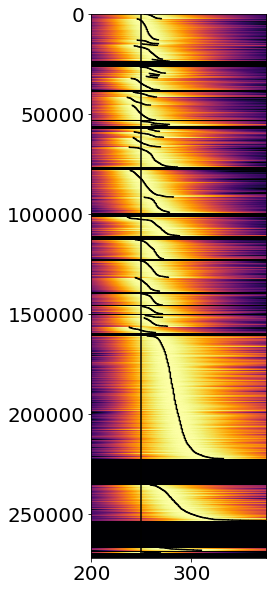

In [263]:
plt.figure(figsize=(10,10))
plt.imshow(stacked_R,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
c = 100
for i in range(len(cum_source_starts_R)-1):
#     start = cum_num_vox[i]+100 #clip long tails slightly
#     end = cum_num_vox[i+1]-100
    num_vox = cum_source_starts_R[i+1] - cum_source_starts_R[i] - 2*c
    plt.plot(peaks_stacked_R[cum_source_starts_R[i]+c:cum_source_starts_R[i+1]-c],
             list(range(cum_dest_starts_R[i],cum_dest_starts_R[i]+num_vox)),color='k')

#plt.plot(peaks_stacked,list(range(len(peaks_stacked))),color='k')
plt.axvline(250,color='k')
# for i in range(len(cum_num_vox)):
#     plt.axhline(cum_num_vox[i],color='w')
plt.xlim(200,375)

(200, 375)

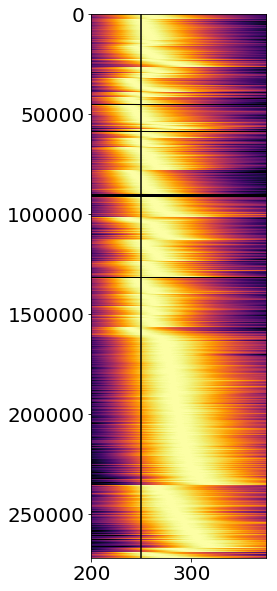

In [233]:
plt.figure(figsize=(10,10))
plt.imshow(stacked_L,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
# for i in range(len(cum_num_vox)-1):
#     start = cum_num_vox[i]+100 #clip long tails slightly
#     end = cum_num_vox[i+1]-100
#     plt.plot(peaks_stacked[start:end],list(range(start,end)),color='k')

#plt.plot(peaks_stacked,list(range(len(peaks_stacked))),color='k')
plt.axvline(250,color='k')
# for i in range(len(cum_num_vox)):
#     plt.axhline(cum_num_vox[i],color='w')
plt.xlim(200,375)

(200, 375)

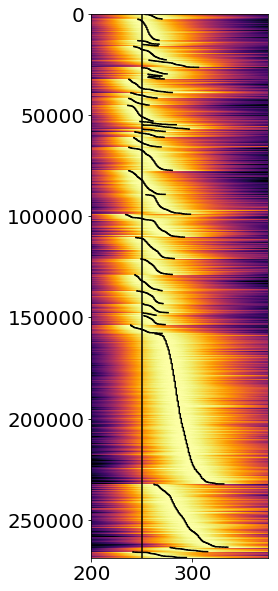

In [190]:
plt.figure(figsize=(10,10))
plt.imshow(stacked,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
for i in range(len(cum_num_vox)-1):
    start = cum_num_vox[i]+100 #clip long tails slightly
    end = cum_num_vox[i+1]-100
    plt.plot(peaks_stacked[start:end],list(range(start,end)),color='k')

#plt.plot(peaks_stacked,list(range(len(peaks_stacked))),color='k')
plt.axvline(250,color='k')
# for i in range(len(cum_num_vox)):
#     plt.axhline(cum_num_vox[i],color='w')
plt.xlim(200,375)

(150, 400)

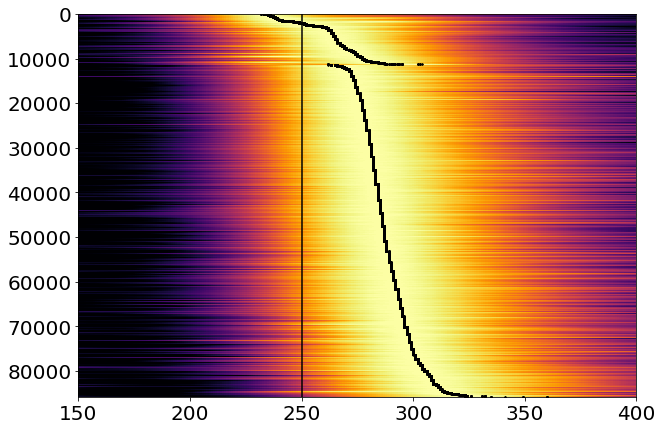

In [137]:
plt.figure(figsize=(10,10))
plt.imshow(stacked,aspect=0.002,vmin=0,vmax=1,cmap='inferno')
plt.plot(peaks_stacked,list(range(len(peaks_stacked))),marker='o',linestyle='',color='k',ms=1)
plt.axvline(250,color='k')
plt.xlim(150,400)

In [127]:
stacked.shape

(85784, 500)

In [121]:
roi_voxels[roi].shape

(11330, 500)

(150, 400)

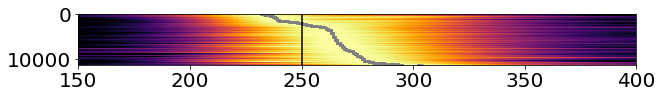

In [120]:
roi = 7
plt.figure(figsize=(10,10))
plt.imshow(roi_voxels[roi][np.argsort(peaks[roi]),:][::-1,::-1],aspect=0.002,vmin=0,vmax=1,cmap='inferno')
#plt.plot(((peaks[roi][np.argsort(peaks[roi])][::-1]-250)*-1)+250,list(range(len(peaks[roi]))),marker='o',linestyle='',color='grey',ms=1)
plt.axvline(250,color='k')
plt.xlim(150,400)

In [90]:
list(range(len(peaks_)))[-1]

14259

In [81]:
range(len(peaks_)).shape

AttributeError: 'range' object has no attribute 'shape'

In [44]:
mask_dilated.shape

(4171804,)

In [130]:
temporal_map[np.where(mask_dilated == 1),:].shape

MemoryError: 

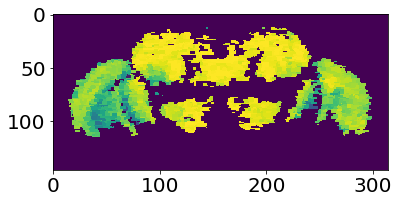

In [131]:
plt.imshow(temporal_map[:,:,60,250].T)

In [ ]:
roi_voxels.shape

In [120]:
temporal_map[:,:,:,:].shape

(314, 146, 91, 500)

In [123]:
np.where(mask_dilated == 1)

(array([ 71,  71,  71, ..., 108, 108, 108]),
 array([37, 37, 37, ..., 38, 39, 39]),
 array([69, 70, 71, ..., 71, 68, 69]))

In [44]:
# ### Get list of voxels that pass a threshold ###

# # find top 60% responding voxels for each behavior
# all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
# thresholds = np.percentile(all_maxs,60,axis=0)

# pooled_above_thresh = []
# for beh_idx in [0,1,2,3]:
#     above_thresh = np.where(all_maxs[:,beh_idx]>=thresholds[beh_idx])
#     pooled_above_thresh.extend(above_thresh)
# pooled_above_thresh = np.unique(pooled_above_thresh)
# print(pooled_above_thresh.shape)

# pooled_below_thresh = [i for i in range(62000) if i not in pooled_above_thresh]
# print(len(pooled_below_thresh

# #################################
# ### Get peaks of these voxels ###
# #################################

# peaks = {}
# peaks_ms = {}
# peaks_unfiltered = {}
# thresholded_filters_norm = {}
# thresholded_filters_norm_unfiltered = {}
# for beh_idx in [0,1,2,3]:
#     print(beh_idx)
#     thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], pooled_below_thresh, axis=0)
    
#     # add gaussian smoothing
#     thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    
#     peaks_ = np.argmax(thresholded_filters,axis=-1)
#     #idx_sort = np.argsort(peaks)
#     maxs = np.max(thresholded_filters,axis=-1)
#     thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
#     peaks[beh_idx] = peaks_
#     peaks_ms[beh_idx] = (peaks_-250)*20
#     thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    
#     thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], pooled_below_thresh, axis=0)
#     maxs = np.max(thresholded_filters_unfiltered,axis=-1)
#     thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
#     thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
#     peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
#     peaks_unfiltered[beh_idx] = peaks_

0
1
2
3


In [37]:
thresholds

array([ 0.67737297,  0.7598277 ,  0.78221916, 39.79982597])

In [24]:
for beh_idx in [0,1,2,3]:
    print(to_delete[beh_idx][0].shape)

(37200,)
(37200,)
(37200,)
(37200,)


In [26]:
62000-37200

24800

In [31]:
# we want to find voxels that have a response in any of the behaviors

all_ = []
for beh_idx in [0,1,2,3]:
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    all_.extend(to_replace)

In [36]:
np.unique(all_).shape

(30570,)

In [32]:
len(to_replace+to_replace)

49600

In [25]:
to_delete[0][0]

array([    1,     3,     4, ..., 61995, 61996, 61999])

(150, 300)

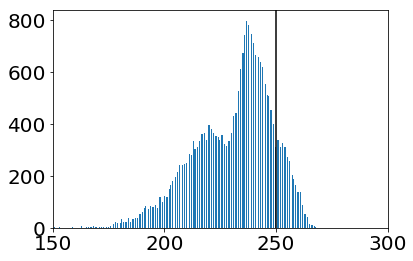

In [18]:
plt.hist(peaks[0],bins=500);
plt.axvline(250,color='k')
plt.xlim(150,300)

(150, 300)

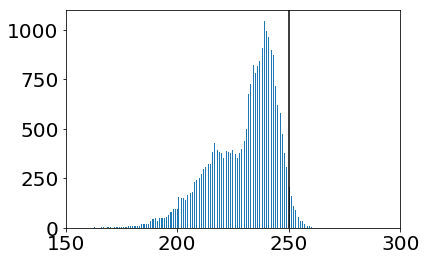

In [21]:
plt.hist(peaks[3],bins=500);
plt.axvline(250,color='k')
plt.xlim(150,300)

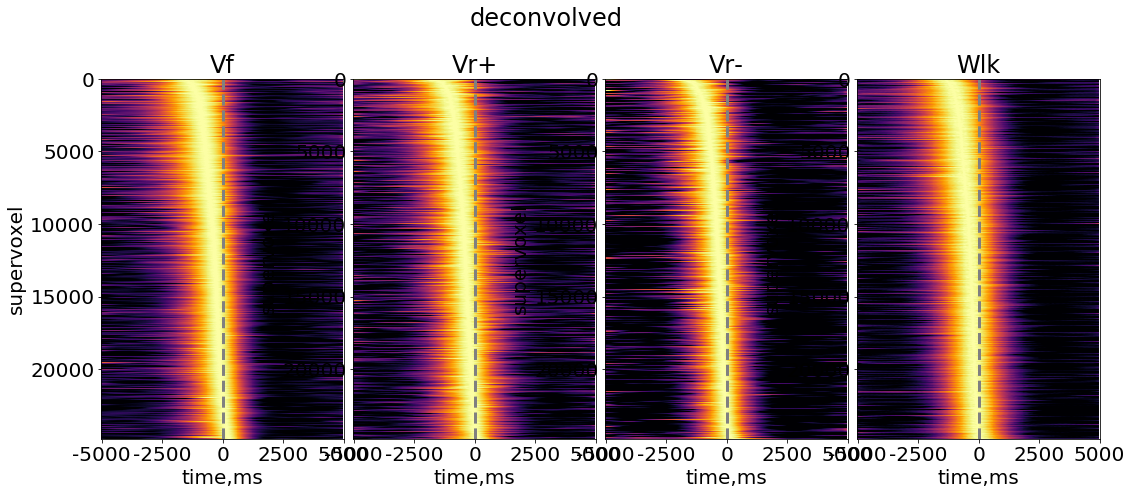

In [68]:
fig = plt.figure(figsize=(10,10))
timepoints = list(range(-5000,0,20)) + list(range(0,5000,20))
behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

for beh_idx in [0,1,2,3]:
    ax = fig.add_axes([beh_idx*.35, 0, .5, .5])
    
    plt.imshow(thresholded_filters_norm[beh_idx][np.argsort(peaks[beh_idx]),:],aspect=.03,cmap='inferno',vmin=0,vmax=1)

    plt.axvline(250,linestyle='--',color='grey',linewidth=3)
    #plt.plot(peaks[beh_idx][list(np.argsort(peaks[beh_idx]))],list(range(len(peaks[beh_idx]))),marker='o',linestyle='',color='grey',ms=1)
    plt.xticks([0,125,250,375,500],[-5000,-2500,0,2500,5000])
    plt.xlabel('time,ms')
    plt.ylabel('supervoxel')
    plt.title(behs[beh_idx])
    #plt.xlim(150,300)

plt.suptitle('deconvolved',x=0.7,y=.6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

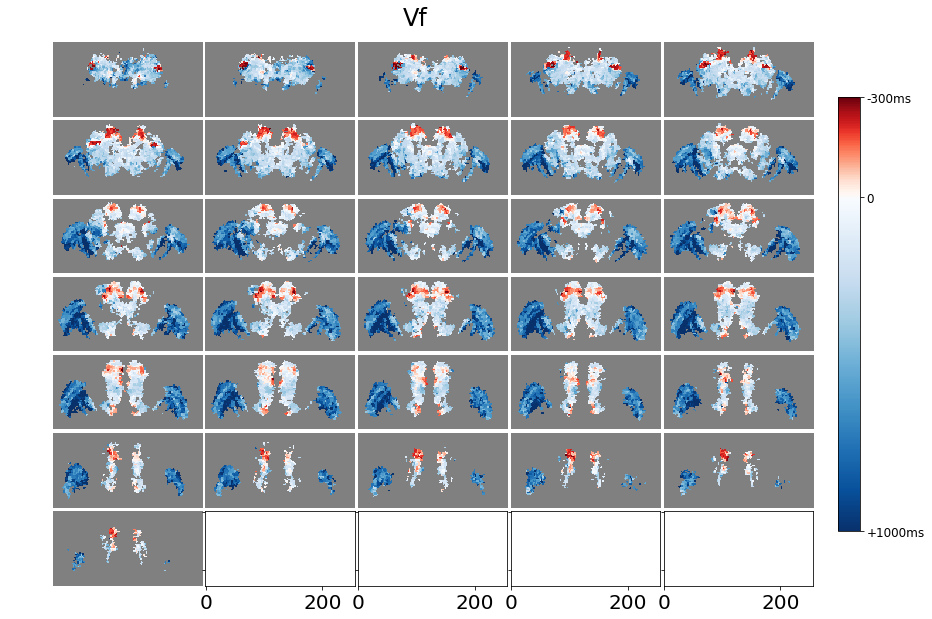

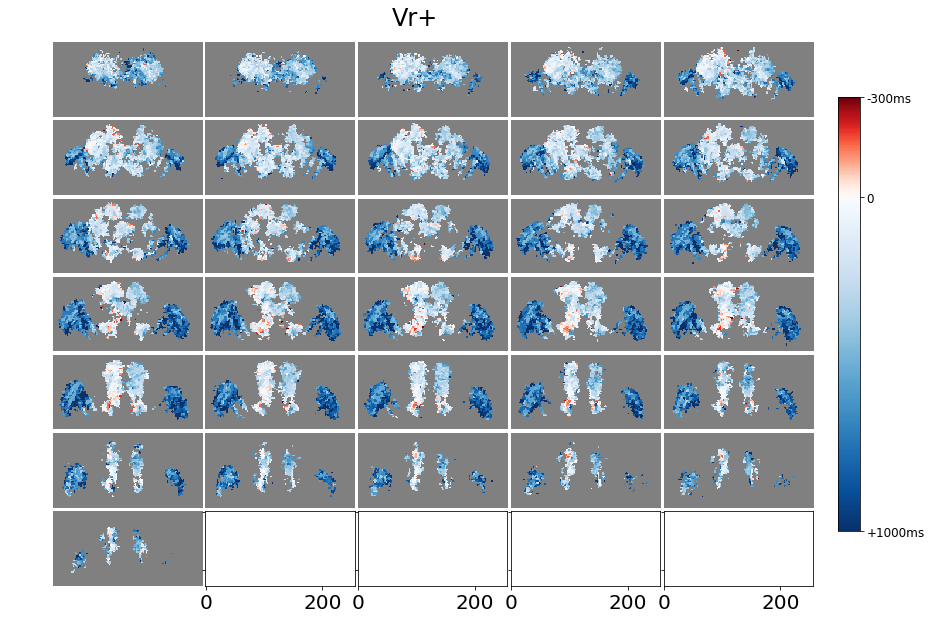

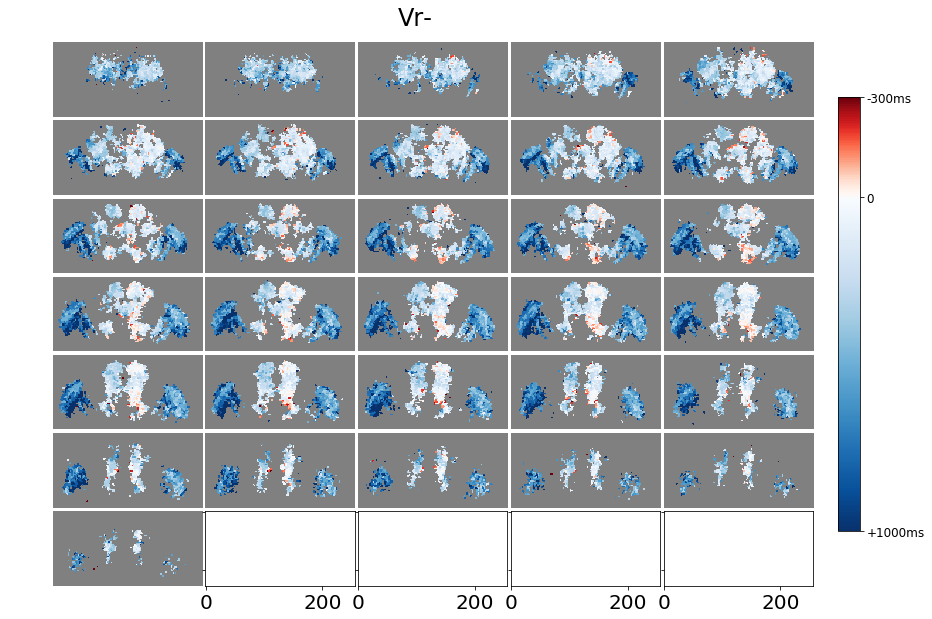

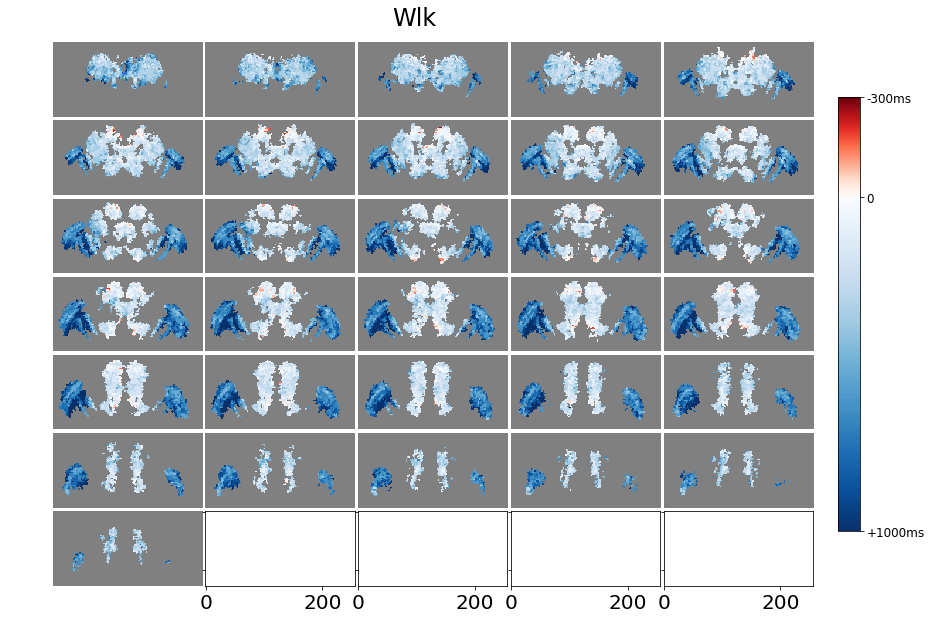

In [98]:
for beh_idx in [0,1,2,3]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = np.nan

    start = 265
    end = 200
    middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
#     start = 235
#     end = 190
    #middle = 250

    # sample the colormaps that you want to use. Use 128 from each so we get 256
    # colors in total
    colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
    colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
        grid[i].axis('off')

    cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['-300ms', '0', '+1000ms'], fontsize=12)

#     cbar = fig.colorbar(cax, ticks=[start, end],shrink=.8, anchor=(.1,.5))
#     cbar.ax.set_yticklabels(['+300ms', '+1000ms'], fontsize=12)

    plt.suptitle(f'{behs[beh_idx]}',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [94]:
50*20

1000

In [13]:
signal = responses_notch[20,cluster_id,0,:]/np.max(responses_notch[20,cluster_id,0,:])

In [26]:
responses_notch.shape

(31, 2000, 4, 500)

In [25]:
all_signals.shape

(62000, 4, 500)

In [43]:
# flip filters in time
all_signals_flipped = all_signals[:,:,::-1]

In [72]:
test = all_signals_flipped[:,0,:]
test.shape

(62000, 500)

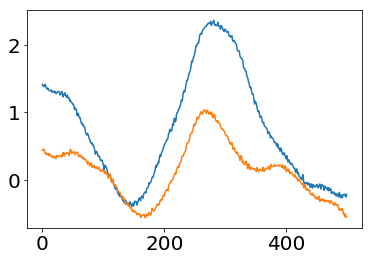

In [45]:
plt.plot(test[0,:])
plt.plot(test[1,:])

In [73]:
# deconvolve

deconv = np.linalg.lstsq(toe, test.T)[0]
deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

In [74]:
# Remove edge artifact
deconv_smooth[:5,:] = deconv_smooth[5,:]
deconv_smooth[-5:,:] = deconv_smooth[-5,:]

In [ ]:
# Flip back to being backwards in time
deconv_smooth = deconv_smooth[::-1,:]

In [ ]:
# flip filters in time
all_signals_flipped = all_signals[:,:,::-1]

# deconvolve
deconv = np.linalg.lstsq(toe, test.T)[0]
deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

# Remove edge artifact
deconv_smooth[:5,:] = deconv_smooth[5,:]
deconv_smooth[-5:,:] = deconv_smooth[-5,:]

# Flip back to being backwards in time
deconv_smooth = deconv_smooth[::-1,:]

In [75]:
deconv_smooth.shape

(500, 62000)

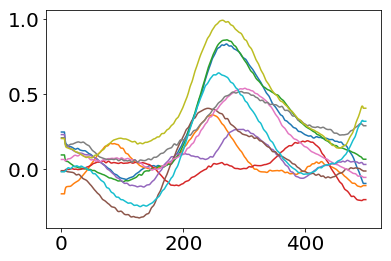

In [76]:
for i in range(10):
    plt.plot(deconv_smooth[:,i])

(-0.4, 1)

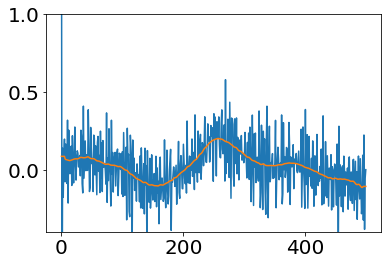

In [71]:
#plt.plot(test)
plt.plot((deconv[:,1]))
plt.plot((deconv_smooth[:,1]))
plt.ylim(-0.4,1)

In [32]:
deconv.shape

(500, 2)

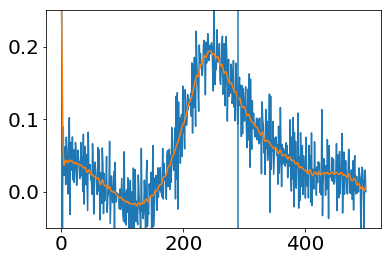

In [18]:
deconv = np.linalg.lstsq(toe, signal[::-1])[0]
plt.plot(deconv)
deconv_smooth = gaussian_filter1d(deconv,sigma=2)
plt.plot(deconv_smooth)
plt.ylim(-.05,.25)
plt.axvline(290)

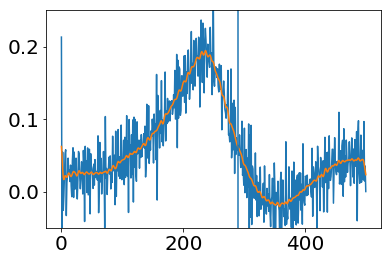

In [15]:
deconv = np.linalg.lstsq(toe, signal)[0]
plt.plot(deconv)
deconv_smooth = gaussian_filter1d(deconv,sigma=2)
plt.plot(deconv_smooth)
plt.ylim(-.05,.25)
plt.axvline(290)

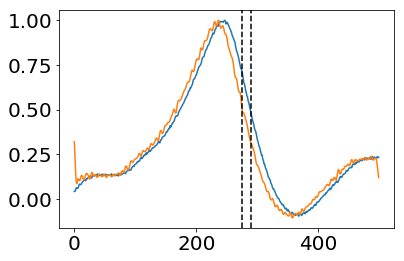

In [17]:
plt.plot(signal)
plt.plot((deconv_smooth/max(deconv_smooth[100:])))
plt.axvline(290,color='k',linestyle='--')
plt.axvline(275,color='k',linestyle='--')

### 300ms gcamp shift!!

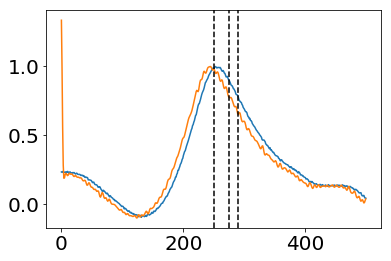

In [20]:
plt.plot(signal[::-1])
plt.plot((deconv_smooth/max(deconv_smooth[100:])))
plt.axvline(290,color='k',linestyle='--')
plt.axvline(275,color='k',linestyle='--')

### 300ms gcamp shift!!
plt.axvline(250,color='k',linestyle='--')
